# Replicating "Unsupervised discovery of visual object class hierarchies" (Sivic et al., 2018)
#### By: Stewart Jamieson
Paper citation: Sivic, J., Russell, B. C., Zisserman, A., Freeman, W. T., & Efros, A. A. (2008). Unsupervised discovery of visual object class hierarchies. 2008 IEEE Conference on Computer Vision and Pattern Recognition, 1–8. https://doi.org/10.1109/CVPR.2008.4587622

Make sure to run the following cell so that the dependencies are loaded!

In [17]:
!pip install -q matplotlib pillow networkx pygraphviz hlda
import os
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import sys
sys.path.append(os.getcwd())
from notebooks.hierarchy_plotting import *
from IPython.display import display
from hlda.sampler import HierarchicalLDA, NCRPNode
try:
    os.chdir(os.getcwd() + '/notebooks')
except:
    pass
import pickle
import gzip

def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol)
        
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object


## The Generative Model
First, let's try to recreate figure #3(a) from the title reference (Sivic et al., 2008). The figure is the following:

![Sivic et al. 2008 Figure #3](figures/sivic_fig3.png)

So, the first thing we need to be able to do is generate our training set data, which will be composed of 'word' observations. To do so, we use the generative model for hLDA presented in the paper:

![Sivic et al. 2008 hLDA Graphical Model](figures/hlda_graphical_model.png)

To generate the visual words $\{w_i\}_{i=1}^N$, we need to first generate:
1. A set distributions of topics over words: $\{\beta_i\}_{i=1}^K$
1. A tree structure $T$ with depth $L$ containing $K$ topics
2. A path $\mathbf{c}$ of length $L$ through the tree for each image (document)
1. A topic distribution $\theta$ over the topics in the path for every image (document)

In Figure #3 of the Sivic paper, the $\beta$ distributions and $T$ are fixed, and we will replicate the same structure. Let's begin by representing the $\beta$ distributions, which show the word distribution of each topic.

In [18]:
def create_band(x=None, y=None, save=None):
    img = Image.new('L', (5, 5), color=255)
    pix = img.load()
    if x is not None:
        for i in range(img.height):
            pix[x, i] = 0
    if y is not None:
        for i in range(img.width):
            pix[i, y] = 0
    if save:
        plt.imsave(save + '.png', np.array(img), cmap='gray', vmin=0, vmax=255)
    return np.array(img, dtype=np.uint8)


The `create_band()` function allows us to create an image of a single band, which will represent a topic. For example, to create a vertical band at x=1, we do the following:


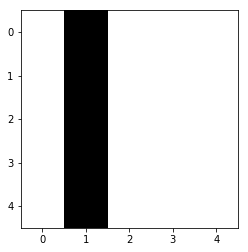

In [19]:
topic = {}
topic[1] = create_band(x=1, save='output/z1')
plt.imshow(Image.fromarray(topic[1]))

Let's enumerate the bands used in the hierarchy from Figure #3:

In [34]:
topic[2] = create_band(y=1, save='output/z2')
topic[3] = create_band(x=3, save='output/z3')
topic[4] = create_band(y=0, save='output/z4')
topic[5] = create_band(x=4, save='output/z5') 
topic[6] = create_band(y=2, save='output/z6')
topic[7] = create_band(x=0, save='output/z7')
topic[8] = create_band(y=3, save='output/z8')

To visualize them, it would help to have the tree structure. For that, let's recreate the tree from Figure #3:


In [35]:
class Node:
    def __init__(self, name, children):
        self.name = name
        self.children = children
        
    def __getitem__(self, item):
        if item == 0:
            return self.name
        elif item == 1:
            return self.children

tree =\
[Node(1, [
    Node(2, [
        Node(4, None), Node(5, None)
    ]),
    Node(3, [
        Node(6, None), Node(7, None), Node(8, None)
    ])
])]

The next step is to plot the tree, which we can do using the `networkx` package:

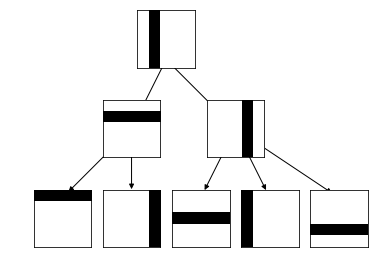

In [36]:
def build_graph_from_tree(G, level, image_pattern):
    for node in level:
        G.add_node(node[0], image=image_pattern.format(node[0]))
        if node[1] is not None:
            build_graph_from_tree(G, node[1], image_pattern)
            for child in node[1]:
                G.add_edge(node[0], child[0])

G = nx.DiGraph()
build_graph_from_tree(G, tree, 'output/z{}.png')
tree_fig : plt.Figure = plt.figure()
plot_image_hierarchy(tree_fig, G)
tree_fig.savefig('output/sivic-3a-top.png')
tree_fig.show()

Now let's go ahead and sample an image from each path of the tree. As in the paper, we are going to use topic proportions sampled from a Dirichlet prior with $\alpha = [50, 30, 10]$. This means that the words will be drawn more often from the root node, less often from the middle node and even less often from the leaf node of the path. Also, since each $\alpha_i \gg 1$, each image will contain a mix of words from all topics.

In [37]:
alpha = np.array([50, 30, 10])
theta = np.random.dirichlet(alpha)
print('theta =', theta)

theta = [0.54727712 0.33077733 0.12194555]


Now all that's left to do is to enumerate all the paths through the tree and generate the word distribution of each document using its topic distribution:

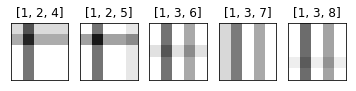

In [38]:
def all_paths(root):
    paths = []
    base_path = [root[0]]
    if root[1] is None:
        return [base_path]
    
    for child in root[1]:
        child_paths = all_paths(child)
        paths.extend([(base_path + child_path) for child_path in child_paths])
    return paths

unique_paths = all_paths(tree[0])
word_dists = []

def get_word_dist(topics, path, alpha):
    theta = np.random.dirichlet(alpha)
    weighted_components = [(topic[z] * theta[i]) for i, z in enumerate(path)]
    return np.sum(weighted_components, axis=0)

# display(tree_fig)
fig = plt.figure()
for i, path in enumerate(unique_paths):
    fig.add_subplot(1, len(unique_paths), i+1)
    word_dists.append(get_word_dist(topic, path, alpha))
    plt.imshow(Image.fromarray(word_dists[-1]))
    plt.title(f'{path}')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

fig.show()


We can tell that our our word distributions are good because they already resemble the sample images from Figure 3. Now all that's left to do is to sample documents from them. To do so, we will treat the pixel intensities as the weights of a categorical distribution:


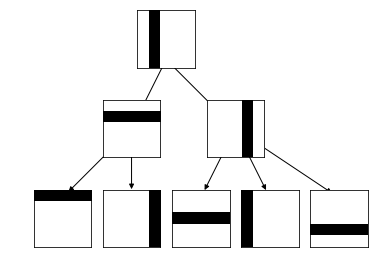

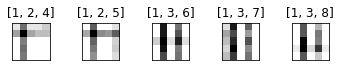

In [39]:
n_words = 250

def sample_document(word_dist):
    flat_word_dist = 255 - word_dist.reshape(-1)
    doc_words = np.random.multinomial(n_words, flat_word_dist / np.sum(flat_word_dist))
    doc_image = 255 - (doc_words.reshape(word_dist.shape).astype(np.uint8) * (255 / np.max(doc_words)))
    return doc_image, doc_words

display(tree_fig)
fig :plt.Figure = plt.figure(figsize=(5,1))
for i, path in enumerate(unique_paths):
    fig.add_subplot(1, len(unique_paths), i+1)
    
    sample_doc = sample_document(word_dists[i])[0]
    plt.imshow(Image.fromarray(sample_doc))
    plt.title(f'{path}')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

fig.tight_layout()
fig.savefig('output/sivic-3a-bottom.png')
fig.show()

So, we can tell that our generative process works since the figure closely matches 3(a) from the paper:

![Sivic et al. 2008 Figure #3](figures/sivic_fig3_small.png)


## Inference on the Model

Now that we can sample documents from arbitrary word distributions, let's generate a larger corpus of documents to use for inference. To do so, we'll need to randomly sample paths from the tree.

For now, we will assume that at each branch the decision is made uniformly over the available choices:

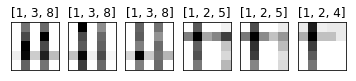

In [40]:
n_documents = 100

def sample_path(node):
    path = [node[0]]
    if node[1] is not None:
        child = np.random.choice(len(node[1]))
        path.extend(sample_path(node[1][child]))
    return path

random_paths = [sample_path(tree[0]) for _ in range(n_documents)]
word_dists = [get_word_dist(topic, path, alpha) for path in random_paths]
corpus = [sample_document(word_dist) for word_dist in word_dists]

fig = plt.figure()
num_plots = 6
for i in range(num_plots):
    fig.add_subplot(1, num_plots, i+1)
    plt.imshow(Image.fromarray(corpus[i][0]))
    plt.title(f'{random_paths[i]}')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

Now that we have a corpus, we perform inference using Gibbs sampling. This requires picking some hyperparameters and putting our corpus into a standard format.

In [41]:
word_corpus = []
for document in corpus:
    words = []
    word_counts = document[1]
    for i in range(word_counts.size):
        words += [i] * word_counts[i]
    word_corpus.append(words)
vocab = list(range(word_counts.size))

n_samples = 11000       # no of iterations for the sampler
alpha = 30.0          # smoothing over level ddddistributions
gamma = 0.3           # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
eta = 0.1             # smoothing over topic-word distributions
num_levels = 3        # the number of levels in the tree
display_topics = 100  # the number of iterations between printing a brief summary of the topics so far
n_words = 5           # the number of most probable words to print for each topic after model estimation
with_weights = False  # whether to print the words with the weights


All that is left to do is to run the sampler and visualize the results:


In [42]:
# Run inference:
model_id = 1
try:
    hlda = load_zipped_pickle(f'hlda_{model_id}.p')
    print('Found saved model! Continuing...')
except:
    hlda = HierarchicalLDA(word_corpus, vocab, alpha=alpha, gamma=gamma, eta=eta, num_levels=num_levels)
hlda.estimate(n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights)

HierarchicalLDA sampling
.................................................................................................... 100
topic 0 (level=0, total_words=8417, documents=100): 1, 6, 16, 11, 21, 
    topic 1 (level=1, total_words=1285, documents=15): 11, 23, 3, 18, 6, 
        topic 2 (level=2, total_words=1237, documents=15): 13, 21, 8, 16, 18, 
    topic 3 (level=1, total_words=3783, documents=46): 13, 8, 23, 18, 3, 
        topic 5 (level=2, total_words=2364, documents=29): 16, 11, 21, 18, 6, 
        topic 6 (level=2, total_words=1448, documents=17): 21, 11, 16, 6, 0, 
    topic 7 (level=1, total_words=3184, documents=39): 9, 16, 6, 8, 7, 
        topic 8 (level=2, total_words=3282, documents=39): 6, 5, 21, 1, 11, 
.................................................................................................... 200
topic 0 (level=0, total_words=8658, documents=100): 11, 1, 6, 16, 21, 
    topic 1 (level=1, total_words=1159, documents=15): 3, 18, 23, 16, 6, 
        topic 2 

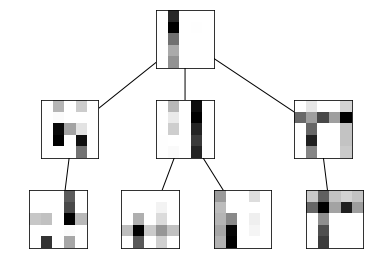

In [45]:
# Visualize results:
def word_counts_to_image(word_counts, save=None):
    image = word_counts.reshape((5,5))
    image.reshape((5,5))
    image = (255 - image * (255 / np.max(image))).astype(np.uint8)
    if save is not None:
        plt.imsave(save + '.png', image, cmap='gray', vmin=0, vmax=255)
    return image

def build_tree_from_hlda(node : NCRPNode, topics = None):
    if topics is None:
        topics = {}
    topics[node.node_id] = word_counts_to_image(node.word_counts, save=f'output/inference-z{node.node_id}')
    if node.children is not None:
        children = []
        for child in node.children:
            child_node, topics = build_tree_from_hlda(child, topics=topics)
            children.append(child_node)
    else:
        children = None
    return Node(node.node_id, children), topics
    
tree, topics = build_tree_from_hlda(hlda.root_node)

G = nx.DiGraph()
build_graph_from_tree(G, [tree], 'output/inference-z{}.png')
result_fig : plt.Figure = plt.figure()
plot_image_hierarchy(result_fig, G)
result_fig.show()

Since it is very slow to converge, it is good to save the result and model:


In [46]:
result_fig.savefig(f'output/sivic-3b-{model_id}.png')
save_zipped_pickle(hlda, f'hlda_{model_id}.p')